# Yelp Business Data Analysis
We will analyze a subset of Yelp's business and review data. The data we will use has been loaded into a s3 bucket: s3://sta9760-proj2-datasets/yelp_data/*.json

Datasource: https://www.kaggle.com/yelp-dataset/yelp-dataset

## Initial Setup

In [1]:
# install packages required for data analysis

sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588623123083_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# list all avaiable packages to confirm installments

sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.0
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

In [3]:
# import packages that we will use in analysis and setup a sparksession

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

## Load Datasets as pyspark Dataframe
Load the datasets (yelp reviews and businesses data) we need from S3 bucket as pyspark dataframe

In [4]:
reviews_data = spark.read.json('s3://sta9760-proj2-datasets/yelp_data/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
business_data = spark.read.json('s3://sta9760-proj2-datasets/yelp_data/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Overview of Businesses Data

In [6]:
# get an overview of the dataframe and show its schema
print("Overview of businesses data")
print(f'Total Columns: {len(business_data.dtypes)}')
print(f'Total Rows: {business_data.count():,}')

business_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overview of businesses data
Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |--

Display the first 5 rows of business_data with the following columns:
* business_id
* name
* city
* state
* categories

In [7]:
business_data.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

---

## Analyzing Categories
Now we are going to perform some basic analysis on categories assoicated with businesses. When it comes to categories, these questions may be asked:
* How many unique categories are represented in this dataset?
* How many businesses are categorized as Pets?
* What are the top 20 most popular categories available?

### Denormalizing the Data of Businesses
There may be more than one categories associated with a business, so first we will denormalize them, mapping a single business id multiple times to each categories it associated with.

In [8]:
from pyspark.sql.functions import split, explode

# create a subset of business data that only contains columns 'business_id' and 'categories'
bus_categories = business_data.select('business_id','categories')

# split categories and mapping each business_id multiple times to each of its categories
bus_dist_catg = bus_categories.withColumn('categories',explode(split('categories',', ')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
bus_dist_catg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

### Total Unique Categories
Now we are ready to answer this question: **How many unique categories are represented in this dataset?**

In [10]:
bus_dist_catg.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

For those who are interested in Pets, let's see **how many business are in this category**.

In [11]:
bus_dist_catg.where(bus_dist_catg.categories=='Pets').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4402

### Top popular categories
Now let's move to the 3rd question: **What are the top 20 most popular categories available?**

In [12]:
bus_dist_catg.groupBy('categories').count().orderBy('count', ascending=False).show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

We can also build a **Bar Chart** for the top 20 popular categories

In [13]:
# first, to plot the data, we need to convert the categories data to pandas dataframe
pd_categories = bus_dist_catg.groupBy('categories').count().orderBy('count', ascending=False).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
pd_categories = pd_categories.set_index('categories')
pd_categories.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               count
categories          
Restaurants    63944
Shopping       34644
Food           32991
Home Services  22487
Beauty & Spas  20520

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

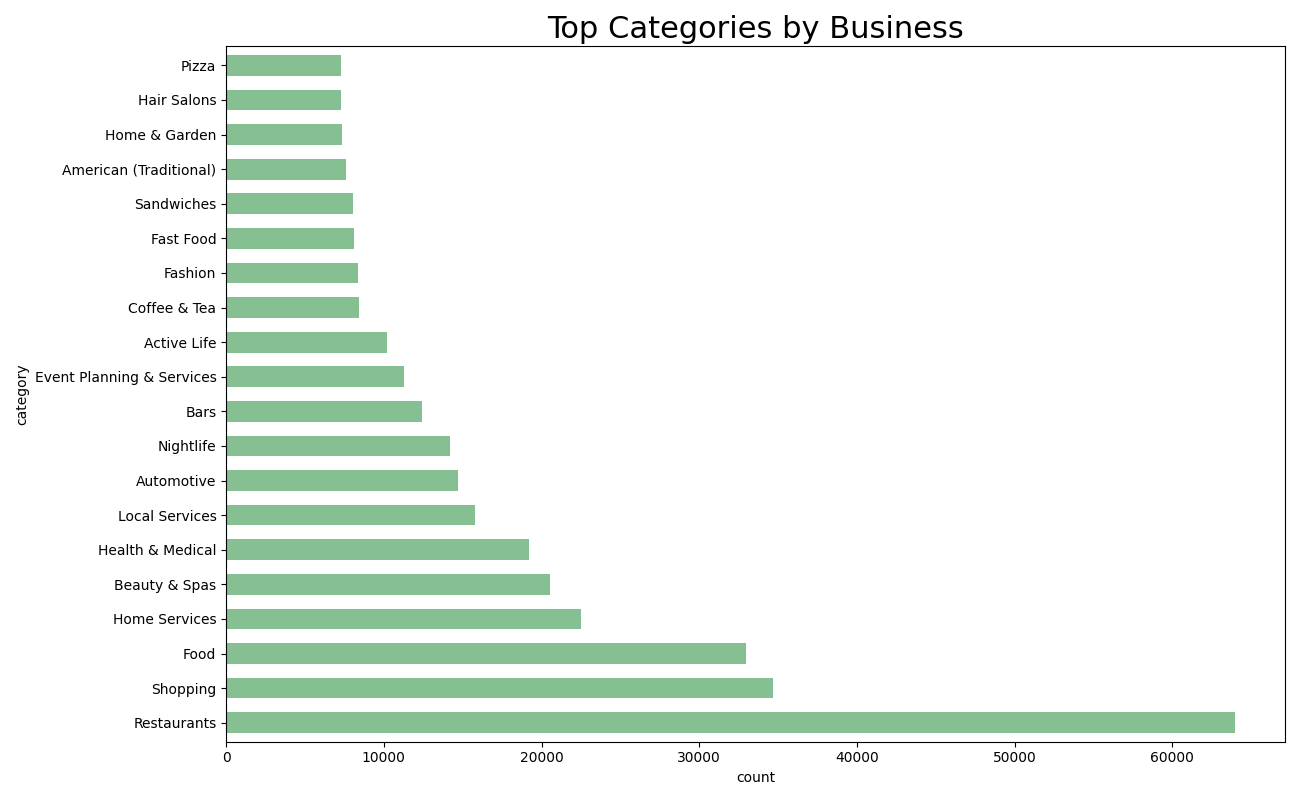

In [15]:
# then plot the top 20 to a bar chart
plt.figure()
pd_categories.head(20).plot.barh(figsize=(13,8),legend=None,color='#86bf91', zorder=2, width=0.6)

plt.title('Top Categories by Business',fontsize=22)
plt.xlabel("count")
plt.ylabel("category")
plt.tight_layout()

%matplot plt

---

## Do Yelp Reviews Skew Negative?
Are the written reviews generally more perssimistic or more optimistic as compared to the overall business rating? It's said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received, how true is it?

Let's try to answer this question with data.
### Overview of Reviews Data

In [16]:
# get an overview of the dataframe and show its schema
print("Overview of reviews data")
print(f'Total Columns: {len(reviews_data.dtypes)}')
print(f'Total Rows: {reviews_data.count():,}')

reviews_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overview of reviews data
Total Columns: 9
Total Rows: 8,021,122
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

List the business_id and stars columns for reviews data

In [17]:
reviews_data.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

**Basic Statistics of Reviews Data**

In [18]:
# Calculate the avarage review star for each business and make the result a new dataframe for further analysis
reviews_avg = reviews_data.groupby('business_id').agg({'stars': 'mean'})
reviews_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vQGZjrDiDBuznOkUe...| 4.454545454545454|
|vyu1WGlnHGv2Z2MVE...|               5.0|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

### Compare Reviews and Businesses Data
What if we join the dataframes of reviews and businesses by business_id?
Then we will be able to see the difference between written review average and rating of each business.

In [19]:
# join reviews_avg and business_data by business_id, and order by avg(stars) from high to low
joined_df = reviews_avg.join(business_data, reviews_avg.business_id==business_data.business_id,'inner').orderBy('avg(stars)', ascending=False).drop(reviews_avg.business_id)

joined_df.select('avg(stars)','stars','name','city','state').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|Carbonation Craft...|Cornelius|   NC|
|       5.0|  5.0|PartyZams Singing...|Las Vegas|   NV|
|       5.0|  5.0|Design Array Gara...|   Peoria|   AZ|
|       5.0|  5.0|Andre Agassi Coll...|Las Vegas|   NV|
|       5.0|  5.0|       The Elf Squad|Charlotte|   NC|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows

Now we can calculate the "skew" between the avg stars of written review and actual stars rating of a businss, and add the result as a new column. The formula we use is as below:

"skew" = (avg(stars) - stars) / stars

If the "skew" is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If "skew" is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [20]:
skew_df = joined_df.withColumn('skew', (joined_df['avg(stars)']-joined_df['stars'])/joined_df['stars']).select('skew','name','city','state').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# calculate the average and median value of skew
print("Difference between written review from users and actual business rating:\n")
print("\tAverage =",skew_df['skew'].mean())
print("\tMedian =",skew_df['skew'].median())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Difference between written review from users and actual business rating:

	Average = 0.001235344665268399
	Median = 0.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

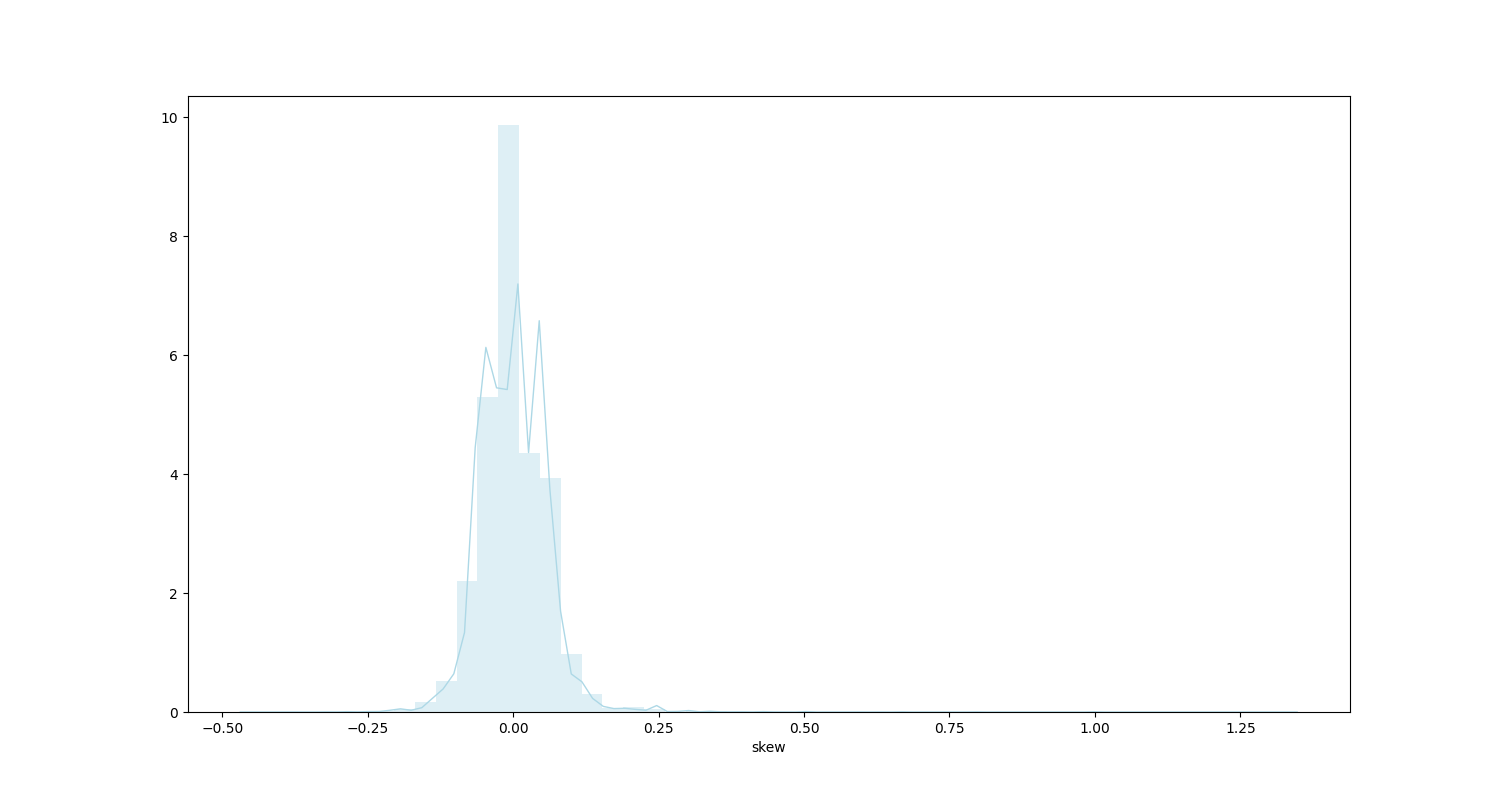

In [21]:
# graph the "skew" with a hist chart with line
plt.figure(figsize=(15,8))
sb.distplot(skew_df['skew'], hist=True, kde=True, bins=50, color = 'lightblue',kde_kws={'linewidth':1})

%matplot plt

---
## Should the Elite be Trusted?
Do elite users make more accurate rating on a business as compared to non elite users? Here we are going to explore an answer for this question.

We will calculate the difference between elite user's rating, average written review rating, and actual business rating, and visualize the difference.


### Load the User Data

In [22]:
users_data = spark.read.json('s3://sta9760-proj2-datasets/yelp_data/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# get an overview of the dataframe and show its schema
print("Overview of User Data")
print(f'Total Columns: {len(users_data.dtypes)}')
print(f'Total Rows: {users_data.count():,}')

users_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overview of User Data
Total Columns: 22
Total Rows: 1,968,703
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

### Elite Users' Review on Business
We need to join the user data and review data by user_id, in order to link every elite user to one or more business

In [24]:
# join the reviews_data with users_data by user_id
joined_reviews = reviews_data.join(users_data, reviews_data.user_id==users_data.user_id,'inner')

# create a new dataframe based on joined_reviews that only contains elite users
elite_reviews = joined_reviews.select('name','elite','stars','business_id').where(joined_reviews.elite!='')
elite_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------------------+-----+--------------------+
|  name|               elite|stars|         business_id|
+------+--------------------+-----+--------------------+
|Nickie|2011,2012,2013,20...|  4.0|L772e6l2Yd0DJEyCB...|
| Linda|2007,2008,2009,20...|  4.0|939j88ceB05Te3D7k...|
| Linda|2007,2008,2009,20...|  3.0|BLIJ-p5wYuAhw6Pp6...|
| Linda|2007,2008,2009,20...|  2.0|5iSmZO0SrKU6EoXK_...|
| Linda|2007,2008,2009,20...|  4.0|GtHu9uGXpn7Jg_Z7v...|
+------+--------------------+-----+--------------------+
only showing top 5 rows

**Basic Statistics of Elite Reviews Data**

In [25]:
# Calculate the avarage review from elite users for each business and make the result a new dataframe for further analysis

elite_reviews_avg = elite_reviews.groupby('business_id').agg({'stars': 'mean'})
elite_reviews_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|BD18SKv935HDmlKrL...| 4.583333333333333|
|j2bx_ctb_ED3zbfSa...| 4.240282685512367|
|--9e1ONYQuAa-CB_R...|4.1916058394160585|
|JsUytp_MuZ4AX5JWf...| 3.776470588235294|
|56HZLqQOcS1FSXqYG...| 4.538461538461538|
+--------------------+------------------+
only showing top 5 rows

### Compare Reviews and Businesses Data

Then we can move to the next step: join elite reviews data with business data and normal reviews data to compare.

In [26]:
# change column name to avoid duplicates

elite_reviews_avg = elite_reviews_avg.withColumnRenamed('avg(stars)','elite_avg')
joined_df = joined_df.withColumnRenamed('avg(stars)','total_avg')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# join elite_reviews_avg and joined_df by business_id

for_compare = elite_reviews_avg.join(joined_df, elite_reviews_avg.business_id == joined_df.business_id,'inner').drop(elite_reviews_avg.business_id)
for_compare = for_compare.select('business_id','total_avg','elite_avg','stars')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Visualize the Difference**

Here we will visualize the difference between elite users' average review and total average review/rating star for each business. Formulas we use are as below:
* diff_review = (elite_avg - total_avg)/total_avg
* diff_business = (elite_avg - stars)/stars

In [28]:
# add the calculated difference as new columns, and convert the pyspark dataframe to pandas dataframe

compare_df = for_compare.withColumn('diff_review', (for_compare['elite_avg']-for_compare['total_avg'])/for_compare['total_avg']).withColumn('diff_business', (for_compare['elite_avg']-for_compare['stars'])/for_compare['stars']).toPandas()
compare_df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              business_id  total_avg  ...  diff_review  diff_business
0  --9e1ONYQuAa-CB_Rrw7Tw   4.117841  ...     0.017913       0.047901
1  -6c_bJblLXUwoWfmYLtH_w   2.333333  ...    -0.571429      -0.600000
2  -I06hkMFrX0KBqu61ik1YA   5.000000  ...     0.000000       0.000000
3  -Qb6U1MotJfpt6OU_uvqQA   5.000000  ...     0.000000       0.000000
4  -RRnldwSqCZT6OpuWKXolg   5.000000  ...     0.000000       0.000000

[5 rows x 6 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

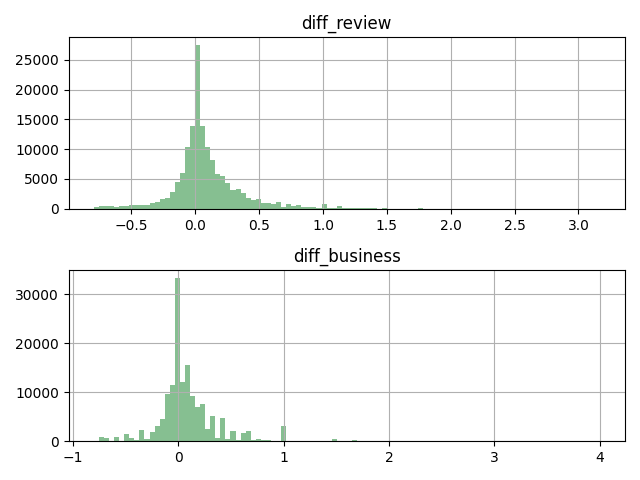

In [41]:
# create a figure with 2 subplots
fig, axes = plt.subplots(2,1)

# draw hist graph for each column
compare_df.hist(column='diff_review', ax=axes[0], bins=100, color='#86bf91')
compare_df.hist(column='diff_business', ax=axes[1], bins=100, color='#86bf91')
plt.tight_layout()

%matplot plt

In [50]:
# calculate the average and median value of diff_review&diff_business column
print("Difference between ratings of ELite users and all users:")
print("\tAverage =",compare_df['diff_review'].mean())
print("\tMedian =",compare_df['diff_review'].median())
print()
print("Difference between ratings of ELite users and actual Business ratings:")
print("\tAverage =",compare_df['diff_business'].mean())
print("\tMedian =",compare_df['diff_business'].median())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Difference between ratings of ELite users and all users:
	Average = 0.08615366475307658
	Median = 0.032967032967032975

Difference between ratings of ELite users and actual Business ratings:
	Average = 0.08830871734064796
	Median = 0.02777777777777768


### Conclusion
According to the graph, in which more of the differences fall into the positive side, and the average and median value of difference calculated above, generally Elite user tend to give a higher rating to a business, compare to the overall reviews and actual business ratings.